# ***Section Who Grade Binary Classification***

This notebook shows the process of classifying section samples into binary who grade (high grade, low grade).

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [1]:
import gc
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from typing import Tuple
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split
from skimage import (filters)
from tqdm import tqdm
from pyimzml.ImzMLParser import ImzMLParser

# Define default font size
plt.rcParams.update({'font.size': 12})

### ***Consistency***
Next, let's make sure notebook is not random:

In [2]:
SEED = 0
# random.seed(SEED)
# np.random.seed(SEED)
# tf.random.set_seed(SEED)

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [3]:
# Define folder that contains the dhg dataset
DHG_PATH = "./../../../DHG/"
# Define folder that contains the preprocessed dataset
PREPROCESSED_PATH = f"{DHG_PATH}/preprocessed"
# Define file that contains dhg metadata
METADATA_PATH = f"{DHG_PATH}/metadata.csv"
# Define folder to save classification models for later use
MODELS_PATH = f"{DHG_PATH}/models/section/binary_who_grade_classification"
# Define path to save plots
PLOTS_PATH = "./../../../plots_and_their_data/section_classification"
# Define mass resolution of the data
MASS_RESOLUTION = 0.025
# Define MSI Spectra dimension
SPECTRA_DIM = 92000
# Define number of epochs
EPOCHS = 100
# Define batch size
BATCH_SIZE = 256
# Define learning rate
LEARNING_RATE = 1e-3
# Mz value to get in order to threshold for tissue
TRESH_MZ = 750
# Mz tolerance value to get in order to threshold for tissue
TRESH_MZ_TOL = 150

### ***Define function to read a MSI***

Next, let's define a function to read a MSI:

In [4]:
def read_msi(p: ImzMLParser) -> Tuple[np.ndarray, np.ndarray]:
  """
    Function to read a continuos imzML parser object into a numpy array.

    Args:
        p (ImzMLParser): The imzML parser.
    Returns:
        Tuple[np.ndarray, np.ndarray]: Numpy 3D matrix where y coordinate
            (axis=0), x coordinate (axis=1), intensities values (axis=2)
            and continuos mzs values.

  """
  # Get shape of mzs values
  max_z = p.mzLengths[0]
  # Get shape of y axis
  max_y = p.imzmldict["max count of pixels y"]
  # Get shape of x axis
  max_x = p.imzmldict["max count of pixels x"]
  # Create empty numpy 3D matrix
  msi = np.zeros((max_y, max_x, max_z))
  # Loop over each coordinate and add to 3D matrix
  for i, (x, y, _) in enumerate(p.coordinates):
    # Get mzs and intensities
    mzs, ints = p.getspectrum(i)
    # Add intensities to x,y coordinate
    msi[y - 1, x - 1, :] = ints
  return mzs, msi

### ***Reading MSI metadata file***

Next, let's read the metadata file:

In [5]:
# Read clinical state annotations csv
metadata_df = pd.read_csv(METADATA_PATH)
# Separate section and replica
s_metadata_df = metadata_df[metadata_df.sample_type == "section"]
r_metadata_df = metadata_df[metadata_df.sample_type == "replica"]

### ***Get single spectra information from all MSI:***

Next, let's get all information except intensities (which needs a lot of memory) for each spectra from all MSI:

In [6]:
# Create dict's to store each sample spectra's mean and std
# for non-tissue spectra's
sample_non_tissue_mean = {}
sample_non_tissue_std = {}

# Create lists to store each spectra's info
spectras_info = []

# Loop over each MSI
for index, row in tqdm(
    metadata_df.iterrows(), total=metadata_df.shape[0], desc="MSI Loop"
):
  # Parse the MSI file
  with ImzMLParser(
      os.path.join(PREPROCESSED_PATH, f"{row.sample_file_name}.imzML")
  ) as reader:
    # Get full msi
    mzs, data = read_msi(reader)

    # Define filter for tissue representative peaks
    
    filter_794 = (
        (mzs >= 794.5 - MASS_RESOLUTION) & (mzs <= 794.5 + MASS_RESOLUTION)
    )
    filter_834 = (
        (mzs >= 834.5 - MASS_RESOLUTION) & (mzs <= 834.5 + MASS_RESOLUTION)
    )
    filter_886 = (
        (mzs >= 886.6 - MASS_RESOLUTION) & (mzs <= 886.6 + MASS_RESOLUTION)
    )
    filter_all = filter_794 | filter_834 | filter_886

    # Get representative peaks accumulative image
    representative_peaks_img = data[:, :, filter_all].sum(axis=-1)

    # threshold
    thresh_img = (
        representative_peaks_img >
        filters.threshold_mean(representative_peaks_img)
    )

    # Get non-tissue spectra's mean
    sample_non_tissue_mean[row.sample_file_name
                          ] = data[~thresh_img, :].mean(axis=0)
    
    # Get non-tissue spectra's std
    sample_non_tissue_std[row.sample_file_name
                         ] = data[~thresh_img, :].std(axis=0)

    # Loop over each spectra
    spectra_info = []
    for idx, (x, y, z) in tqdm(
        enumerate(reader.coordinates), total=len(reader.coordinates),
        desc="Spectra Loop"
    ):
      # Append spectra info
      spectras_info.append(
          [
              row.sample_file_name, row.sample_type, row.sample_number,
              row.histology, row.who_grade, x, y, idx,
              (True if thresh_img[y - 1, x - 1] else False)
          ]
      )

# Convert to data frame
spectras_info = pd.DataFrame(
    spectras_info, columns=[
        "file_name", "sample_type", "sample_number", "histology", "who_grade",
        "x_coordinate", "y_coordinate", "idx", "is_tissue"
    ]
)
spectras_info["label"] = (spectras_info["who_grade"] > 2).astype(int)

# Separate section and replica
s_spectras_info = spectras_info[spectras_info.sample_type == "section"]
r_spectras_info = spectras_info[spectras_info.sample_type == "replica"]

MSI Loop: 100%|██████████| 48/48 [02:28<00:00,  3.09s/it]


### ***MSI parsers opening:***

Next, let's create parser for each MSI in order to read spectra's for the model:

In [7]:
# Opening parsers
parsers = {
    file_name: ImzMLParser(os.path.join(PREPROCESSED_PATH, f"{file_name}.imzML"))
    for file_name in metadata_df.sample_file_name.unique()
}

### ***Dataset generator:***

Next, let's create a dataset generator for the model:

In [8]:
def map_record(file_name: tf.Tensor, idx: tf.Tensor,
               label: tf.Tensor) -> Tuple[np.ndarray, int]:
  """Function to map a record to model input (spectra) and output (label).

  Args:
      file_name (tf.Tensor): Record file name to get spectra.
      idx (tf.Tensor): Record index to get spectra.
      label (tf.Tensor): Record label.

  Returns:
      Tuple[np.ndarray, int]: input (spectra) and output (label).
  
  """
  # Decoding from the EagerTensor object
  file_name, idx, label = (
    file_name.numpy(), idx.numpy(), label.numpy()
  )

  # Decode bytes to str
  file_name = file_name.decode('utf-8')

  # Reading spectra from parser
  _, spectra = parsers[file_name].getspectrum(idx)

  # Apply standardization
  spectra = (
    (spectra - sample_non_tissue_mean[file_name]) /
    sample_non_tissue_std[file_name]
  )

  # Return spectra and label
  return (spectra, label)


def _fixup_shape(x: tf.Tensor, y: tf.Tensor):
  """ Function to Fix the implicit inferring of the shapes of the
  output Tensors.

  Args:
      x (tf.Tensor): input (spectra)
      y (tf.Tensor): output (label)

  Returns:
      Tuple[np.ndarray, np.ndarray]: input (spectra) and output (label) with
        correct shape.
  
  """
  x.set_shape([SPECTRA_DIM])
  y.set_shape([])
  return x, y


def create_ds(
    file_names: np.ndarray, indexes: np.ndarray, labels: np.ndarray,
    batch_size: int, shuffle: bool
) -> tf.data.Dataset:
  """Function to create a dataset for model

  Args:
      file_names (np.ndarray): file names of the dataset.
      indexes (np.ndarray): indexes of the dataset.
      labels (np.ndarray): labels of the dataset.
      batch_size (int): batch size.
      shuffle (bool): flag to indicate if to shuffle or not.

  Returns:
      tf.data.Dataset: dataset
  """
  # Create dataset from indexes
  ds = tf.data.Dataset.from_tensor_slices((file_names, indexes, labels))
  # Shuffle the data
  if shuffle:
    ds = ds.shuffle(len(data), seed=SEED)
  # Map index to spectra
  ds = ds.map(
      lambda i, j, k: tf.py_function(
          func=map_record, inp=[i, j, k], Tout=[tf.float32, tf.float32]
      )
  )
  # Fix the implicit inferring of the shapes of the
  # output Tensors
  ds = ds.map(_fixup_shape)
  # Batch the spectra's
  ds = ds.batch(batch_size)
  # Prefetch batch's to make sure that a batch is ready to
  # be served at all time
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

### ***Classification model:***

Next, let's create a classification dense neural network model:

In [9]:
def get_model() -> tf.keras.Model:
  """Function to generate classification model.

  Returns:
      tf.keras.Model: classification model.
  
  """
  return tf.keras.Sequential(
    [
      layers.InputLayer(input_shape=(SPECTRA_DIM,)),
      layers.Dropout(0.5),
      layers.Dense(1024),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.3),
      layers.Dense(1024),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.3),
      layers.Dense(512),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.3),
      layers.Dense(1, activation='sigmoid')
    ]
  )

In [ ]:
def get_model() -> tf.keras.Model:
  """Function to generate classification model.

  Returns:
      tf.keras.Model: classification model.
  
  """
  return tf.keras.Sequential(
    [
      layers.InputLayer(input_shape=(SPECTRA_DIM,)),
      layers.GaussianNoise(0.01),
      #layers.Dropout(0.66),
      layers.Dense(1024),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),
      #layers.Dropout(0.66),
      layers.Dense(1024),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),
      #layers.Dropout(0.66),
      layers.Dense(512),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),
      #layers.Dropout(0.66),
      layers.Dense(256),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),
      #layers.Dropout(0.66),
      layers.Dense(1, activation='sigmoid')
    ]
  )

In [51]:
def get_model() -> tf.keras.Model:
  """Function to generate classification model.

  Returns:
      tf.keras.Model: classification model.
  
  """
  return tf.keras.Sequential(
    [
      layers.Input(shape=(SPECTRA_DIM,1)),
      layers.Conv1D(filters=64, kernel_size=11, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Flatten(),
      layers.Dense(32, activation='relu'),
      layers.Dense(1, activation='sigmoid')
    ]
  )

In [49]:
get_model().summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 91990, 8)          96        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 45995, 8)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 367960)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                11774752  
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 11,774,881
Trainable params: 11,774,881
Non-trainable params: 0
_________________________________________________________________


### ***Training:***
Next, let"s create a classification model for each leave one sample out option:

In [10]:
# Define dict's to store validation and trainig metrics
train_metrics = {}
validation_metrics = {}

# Loop over each image
for exclude_image, group in tqdm(s_metadata_df.groupby("file_name")):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get all spectra's in the exclude_image to exclude them
  exclude_spectras = s_spectras_info["sample_number"].isin(
      group.sample_number.to_list()
  )

  # Create filter for training data - does not include the excluded image
  # and only include tissue spectra's
  train_filter = ((~exclude_spectras) & s_spectras_info.is_tissue)

  # Get x and y data for training
  X = s_spectras_info.loc[train_filter, ["file_name", "idx"]]
  y = s_spectras_info.loc[train_filter, "label"]

  # Split to train and validation set
  X_train, X_val, y_train, y_val = train_test_split(
      X, y, test_size=0.2, random_state=SEED, stratify=y
  )

  # Create data generators
  train_generator = create_ds(
      X_train.iloc[:, 0].to_numpy(), X_train.iloc[:, 1].to_numpy(),
      y_train.to_numpy(), BATCH_SIZE, True
  )
  validation_generator = create_ds(
      X_val.iloc[:, 0].to_numpy(), X_val.iloc[:, 1].to_numpy(),
      y_val.to_numpy(), BATCH_SIZE, True
  )

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      '.', f"approach_3/excluded_{exclude_image}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False,
      monitor="val_binary_accuracy", mode="max", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(
      optimizer, loss=losses.BinaryCrossentropy(),
      metrics=["binary_accuracy"]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPOCHS,
      callbacks=[model_checkpoint_callback, model_es_callback]
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_image] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_image] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/100
68/68 [==============================] - 26s 355ms/step - loss: 0.1032 - binary_accuracy: 0.9613 - val_loss: 0.0305 - val_binary_accuracy: 0.9882
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 11-11-12-s\assets
Epoch 2/100
68/68 [==============================] - 26s 377ms/step - loss: 0.0167 - binary_accuracy: 0.9946 - val_loss: 0.0114 - val_binary_accuracy: 0.9961
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 11-11-12-s\assets
Epoch 3/100
68/68 [==============================] - 25s 368ms/step - loss: 0.0068 - binary_accuracy: 0.9977 - val_loss: 0.0136 - val_binary_accuracy: 0.9951
Epoch 4/100
68/68 [==============================] - 26s 387ms/step - loss: 0.0065 - binary_accuracy: 0.9983 - val_loss: 0.0267 - val_binary_accuracy: 0.9930
Epoch 5/100
68/68 [==============================] - 27s 400ms/step - loss: 0.0051 - binary_accuracy: 0.9988 - val_loss: 0.0211 - val_binary_accuracy: 0.9942
Epoch 6/100
68/68 [==============================] - 2

 12%|█▎        | 1/8 [03:42<25:54, 222.05s/it]

##############################
Epoch 1/100
73/73 [==============================] - 31s 421ms/step - loss: 0.0943 - binary_accuracy: 0.9638 - val_loss: 0.0257 - val_binary_accuracy: 0.9903
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 14-13-s\assets
Epoch 2/100
73/73 [==============================] - 40s 543ms/step - loss: 0.0132 - binary_accuracy: 0.9965 - val_loss: 0.0133 - val_binary_accuracy: 0.9961
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 14-13-s\assets
Epoch 3/100
73/73 [==============================] - 29s 396ms/step - loss: 0.0061 - binary_accuracy: 0.9983 - val_loss: 0.0288 - val_binary_accuracy: 0.9929
Epoch 4/100
73/73 [==============================] - 29s 395ms/step - loss: 0.0038 - binary_accuracy: 0.9988 - val_loss: 0.0229 - val_binary_accuracy: 0.9940
Epoch 5/100
73/73 [==============================] - 31s 431ms/step - loss: 0.0030 - binary_accuracy: 0.9989 - val_loss: 0.0246 - val_binary_accuracy: 0.9929
Epoch 6/100
73/73 [==========

 25%|██▌       | 2/8 [07:58<24:12, 242.10s/it]

##############################
Epoch 1/100
75/75 [==============================] - 34s 439ms/step - loss: 0.0937 - binary_accuracy: 0.9658 - val_loss: 0.0413 - val_binary_accuracy: 0.9842
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 16-15-s\assets
Epoch 2/100
75/75 [==============================] - 29s 386ms/step - loss: 0.0099 - binary_accuracy: 0.9973 - val_loss: 0.0161 - val_binary_accuracy: 0.9950
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 16-15-s\assets
Epoch 3/100
75/75 [==============================] - 29s 392ms/step - loss: 0.0035 - binary_accuracy: 0.9991 - val_loss: 0.0122 - val_binary_accuracy: 0.9960
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 16-15-s\assets
Epoch 4/100
75/75 [==============================] - 29s 392ms/step - loss: 0.0029 - binary_accuracy: 0.9993 - val_loss: 0.0189 - val_binary_accuracy: 0.9946
Epoch 5/100
75/75 [==============================] - 29s 386ms/step - loss: 0.0018 - binary_accuracy: 0.9994 - v

 38%|███▊      | 3/8 [12:46<21:56, 263.28s/it]

##############################
Epoch 1/100
77/77 [==============================] - 32s 410ms/step - loss: 0.0857 - binary_accuracy: 0.9684 - val_loss: 0.0830 - val_binary_accuracy: 0.9766
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 19-18-s\assets
Epoch 2/100
77/77 [==============================] - 30s 388ms/step - loss: 0.0104 - binary_accuracy: 0.9965 - val_loss: 0.0195 - val_binary_accuracy: 0.9937
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 19-18-s\assets
Epoch 3/100
77/77 [==============================] - 33s 426ms/step - loss: 0.0055 - binary_accuracy: 0.9982 - val_loss: 0.0288 - val_binary_accuracy: 0.9935
Epoch 4/100
77/77 [==============================] - 30s 393ms/step - loss: 0.0033 - binary_accuracy: 0.9989 - val_loss: 0.0221 - val_binary_accuracy: 0.9945
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 19-18-s\assets
Epoch 5/100
77/77 [==============================] - 30s 389ms/step - loss: 0.0016 - binary_accuracy: 0.9993 - v

 50%|█████     | 4/8 [17:08<17:31, 262.87s/it]

##############################
Epoch 1/100
60/60 [==============================] - 24s 392ms/step - loss: 0.0836 - binary_accuracy: 0.9668 - val_loss: 0.1668 - val_binary_accuracy: 0.9390
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 29-25-23-21-20-s\assets
Epoch 2/100
60/60 [==============================] - 25s 414ms/step - loss: 0.0032 - binary_accuracy: 0.9995 - val_loss: 0.0017 - val_binary_accuracy: 0.9995
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 29-25-23-21-20-s\assets
Epoch 3/100
60/60 [==============================] - 23s 389ms/step - loss: 0.0010 - binary_accuracy: 0.9998 - val_loss: 0.0032 - val_binary_accuracy: 0.9987
Epoch 4/100
60/60 [==============================] - 23s 390ms/step - loss: 0.0012 - binary_accuracy: 0.9997 - val_loss: 0.0037 - val_binary_accuracy: 0.9979
Epoch 5/100
60/60 [==============================] - 23s 385ms/step - loss: 0.0013 - binary_accuracy: 0.9995 - val_loss: 0.0071 - val_binary_accuracy: 0.9974
Epoch 6/100

 62%|██████▎   | 5/8 [20:36<12:08, 242.80s/it]

##############################
Epoch 1/100
78/78 [==============================] - 34s 421ms/step - loss: 0.0931 - binary_accuracy: 0.9655 - val_loss: 0.0847 - val_binary_accuracy: 0.9723
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 6-7-s\assets
Epoch 2/100
78/78 [==============================] - 32s 413ms/step - loss: 0.0130 - binary_accuracy: 0.9959 - val_loss: 0.0166 - val_binary_accuracy: 0.9948
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 6-7-s\assets
Epoch 3/100
78/78 [==============================] - 31s 401ms/step - loss: 0.0074 - binary_accuracy: 0.9978 - val_loss: 0.0161 - val_binary_accuracy: 0.9964
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 6-7-s\assets
Epoch 4/100
78/78 [==============================] - 31s 398ms/step - loss: 0.0038 - binary_accuracy: 0.9989 - val_loss: 0.0212 - val_binary_accuracy: 0.9954
Epoch 5/100
78/78 [==============================] - 33s 422ms/step - loss: 0.0019 - binary_accuracy: 0.9996 - val_los

 75%|███████▌  | 6/8 [25:42<08:48, 264.35s/it]

##############################
Epoch 1/100
59/59 [==============================] - 25s 415ms/step - loss: 0.0805 - binary_accuracy: 0.9702 - val_loss: 0.0366 - val_binary_accuracy: 0.9880
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 8-12-5-4-3-2-s\assets
Epoch 2/100
59/59 [==============================] - 25s 425ms/step - loss: 0.0091 - binary_accuracy: 0.9972 - val_loss: 0.0102 - val_binary_accuracy: 0.9963
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 8-12-5-4-3-2-s\assets
Epoch 3/100
59/59 [==============================] - 24s 399ms/step - loss: 0.0027 - binary_accuracy: 0.9991 - val_loss: 0.0111 - val_binary_accuracy: 0.9968
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 8-12-5-4-3-2-s\assets
Epoch 4/100
59/59 [==============================] - 24s 415ms/step - loss: 0.0017 - binary_accuracy: 0.9994 - val_loss: 0.0108 - val_binary_accuracy: 0.9963
Epoch 5/100
59/59 [==============================] - 24s 398ms/step - loss: 0.0024 - binary

 88%|████████▊ | 7/8 [30:34<04:33, 273.55s/it]

##############################
Epoch 1/100
78/78 [==============================] - 33s 405ms/step - loss: 0.0865 - binary_accuracy: 0.9680 - val_loss: 0.0408 - val_binary_accuracy: 0.9885
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 9-10-s\assets
Epoch 2/100
78/78 [==============================] - 32s 406ms/step - loss: 0.0123 - binary_accuracy: 0.9962 - val_loss: 0.0106 - val_binary_accuracy: 0.9968
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 9-10-s\assets
Epoch 3/100
78/78 [==============================] - 30s 388ms/step - loss: 0.0074 - binary_accuracy: 0.9979 - val_loss: 0.0213 - val_binary_accuracy: 0.9933
Epoch 4/100
78/78 [==============================] - 31s 398ms/step - loss: 0.0071 - binary_accuracy: 0.9978 - val_loss: 0.0151 - val_binary_accuracy: 0.9957
Epoch 5/100
78/78 [==============================] - 30s 387ms/step - loss: 0.0044 - binary_accuracy: 0.9985 - val_loss: 0.0220 - val_binary_accuracy: 0.9933
Epoch 6/100
78/78 [============

100%|██████████| 8/8 [34:56<00:00, 262.01s/it]

##############################


In [11]:
train_metrics

{'HG 11-11-12-s': [0.003114659572020173, 0.9994204044342041],
 'HG 14-13-s': [0.0013648803578689694, 0.999622106552124],
 'HG 16-15-s': [0.0008605518960393965, 0.9998436570167542],
 'HG 19-18-s': [0.0010928235715255141, 0.9997456669807434],
 'HG 29-25-23-21-20-s': [0.004477119538933039, 0.9985665082931519],
 'HG 6-7-s': [0.0017590300412848592, 0.9995490312576294],
 'HG 8-12-5-4-3-2-s': [0.0019693702924996614, 0.9996652603149414],
 'HG 9-10-s': [0.001986515009775758, 0.9996455907821655]}

In [12]:
validation_metrics

{'HG 11-11-12-s': [0.011355563066899776, 0.9960593581199646],
 'HG 14-13-s': [0.013312086462974548, 0.9961140155792236],
 'HG 16-15-s': [0.012180076912045479, 0.9960392117500305],
 'HG 19-18-s': [0.02213234268128872, 0.9945077300071716],
 'HG 29-25-23-21-20-s': [0.001741394866257906, 0.9994787573814392],
 'HG 6-7-s': [0.016142163425683975, 0.9963920712471008],
 'HG 8-12-5-4-3-2-s': [0.011688966304063797, 0.9973226189613342],
 'HG 9-10-s': [0.010641009546816349, 0.996759831905365]}

### ***Evaluation on tissue spectra's:***

Next, let's get the prediction of each of left out sample spectra's:

In [13]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    s_metadata_df.iterrows(), total=s_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for test data
  test_filter = (
      (s_spectras_info["file_name"] == row.sample_file_name) &
      s_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = s_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = s_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False
  )

  # Get saved model path
  model_path = os.path.join(
      '.', f"approach_3/excluded_{row.file_name}/"
  )

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop:  88%|████████▊ | 21/24 [01:38<00:13,  4.46s/it]

MSI Loop:  96%|█████████▌| 23/24 [01:46<00:04,  4.22s/it]

MSI Loop: 100%|██████████| 24/24 [01:51<00:00,  4.64s/it]


Next, let's get some statistics about each left out sample predictions:

In [14]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
#
model_eval.set_index("sample_left_out", inplace=True)
# Print statistics
model_eval

,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
sample_left_out,,,,,,,
HG 11_1-s,0.5502064824,1.0000000000,0.9999996424,0.9974513650,0.0228801426,1,1
HG 11_2-s,0.0915933698,1.0000000000,0.9999997616,0.9963477254,0.0422288850,1,1
HG 12-s,0.0142167648,0.9999998808,0.9986253977,0.9665580988,0.1096456125,1,1
HG 14-s,0.0000000307,0.9999992847,0.9847943187,0.7280476093,0.3946934044,1,1
HG 13-s,0.0000000267,0.9999924898,0.7886348963,0.5830038786,0.4188668132,1,1
HG 15-s,0.0000000000,0.9999985695,0.8731632829,0.5716436505,0.4565120339,1,1
HG 16-s,0.0000000000,0.9996536970,0.0000000000,0.0134077733,0.0999432430,0,0
HG 19-s,0.9986233711,1.0000000000,0.9998949766,0.9998705387,0.0001172275,0,1
HG 18-s,0.9974387884,0.9999995232,0.9997972846,0.9997556210,0.0002247882,0,1


Next, let's evaluate the classification performance image-wise:

In [15]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.708
Balanced  Accuracy: 0.625
Precision: 0.737
Recall: 0.875
F1 score: 0.800


Next, let's plot the roc curve image-wise:

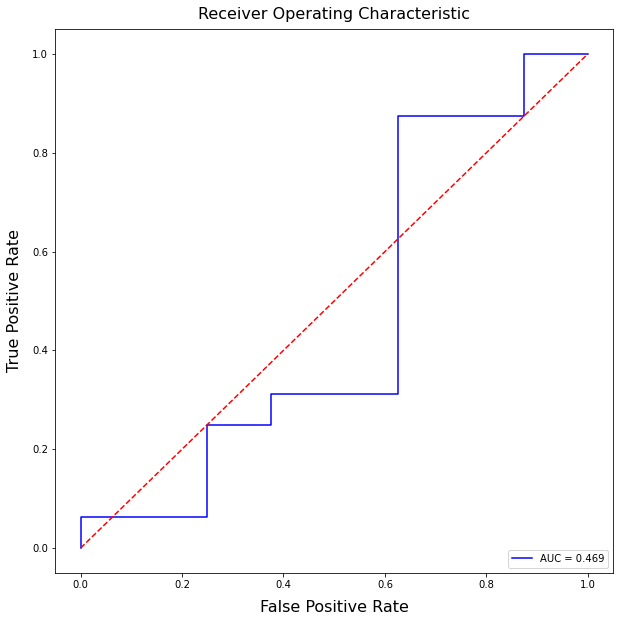

In [16]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.show()

Next, let's plot the precision-recall curve image-wise:

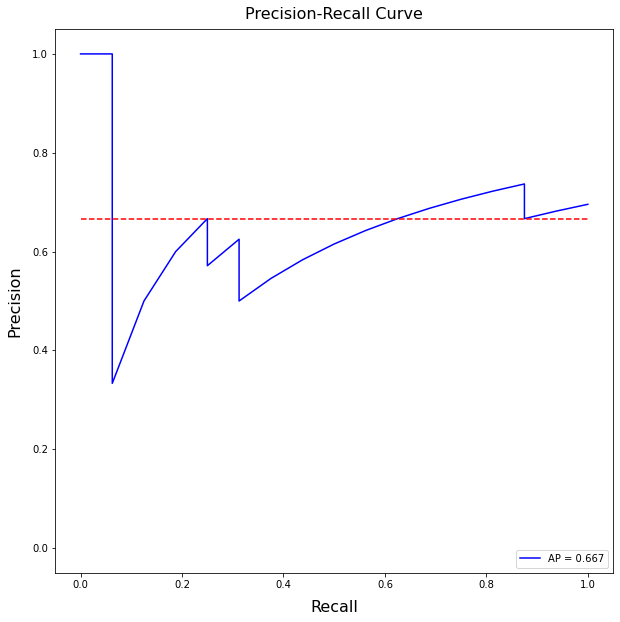

In [17]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [18]:
# Create single array of predictions and labels 
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.605
Balanced  Accuracy: 0.548
Precision: 0.738
Recall: 0.684
F1 score: 0.710


Next, let's plot the roc curve spectra-wise:

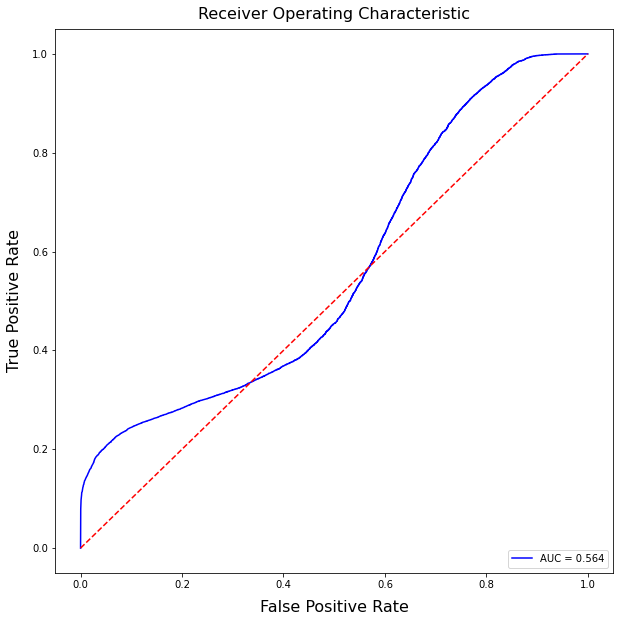

In [19]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

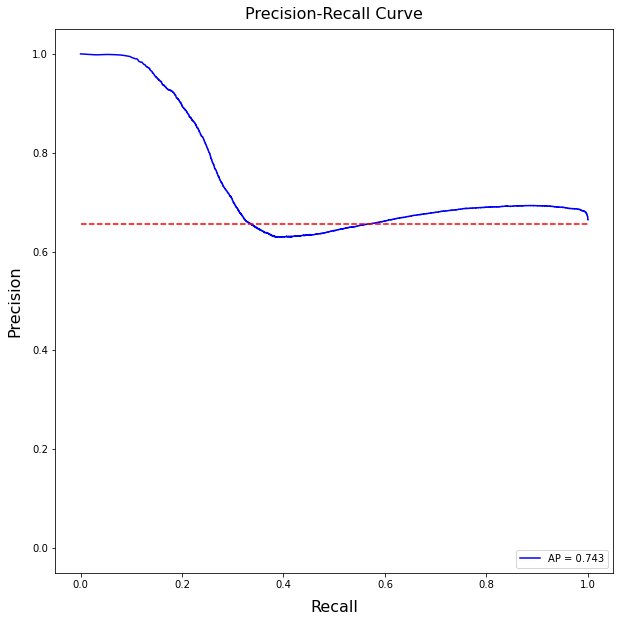

In [20]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  predictions_and_labels[:, 1], predictions_and_labels[:, 0])
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1]==1) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.show()

Next, let's plot the prediction heatmap for every sample:

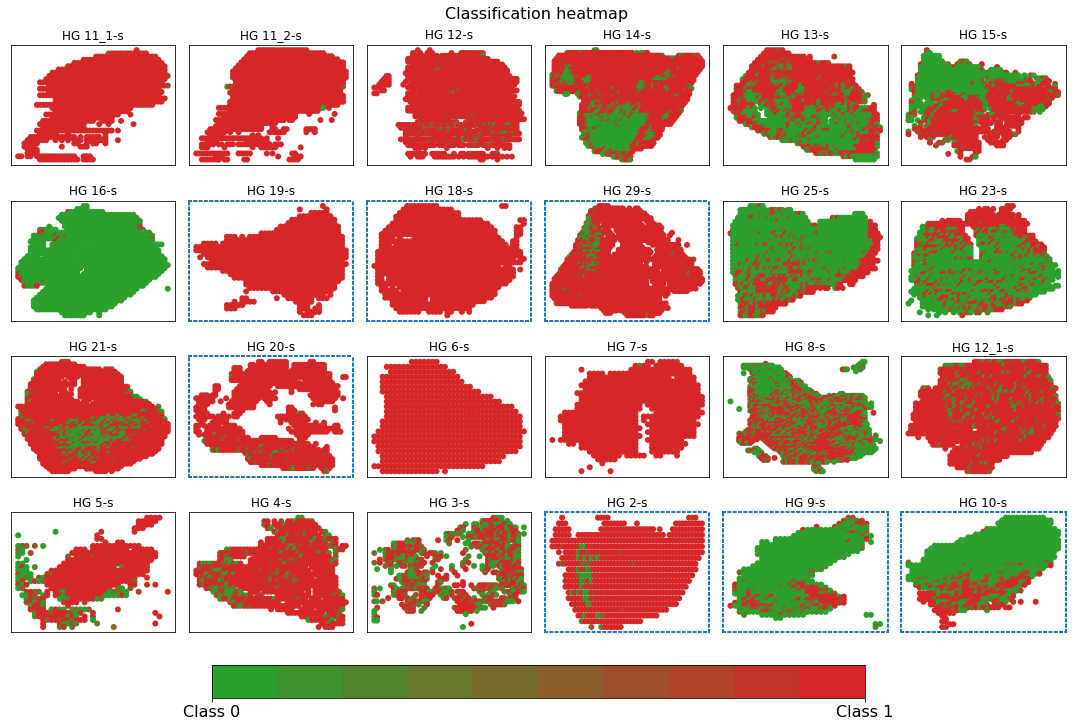

In [21]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      s_spectras_info[(s_spectras_info.file_name == key) &
                      s_spectras_info.is_tissue].x_coordinate - 1,
      s_spectras_info[(s_spectras_info.file_name == key) &
                      s_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key}")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.show()

Next, let's plot the prediction distribution for every sample:

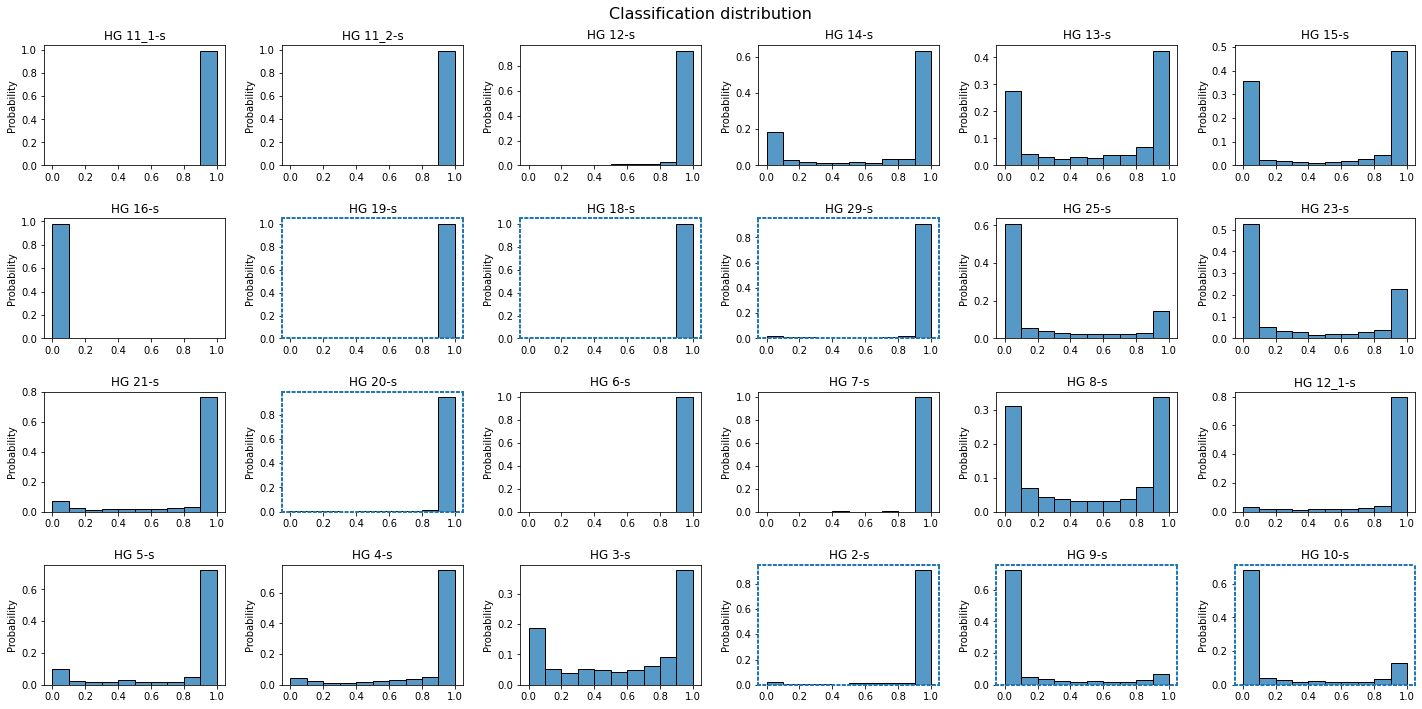

In [22]:
# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key}")

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.show()

### ***Evaluation on nonn-tissue spectra's:***

Next, let's get the prediction of each of left out sample spectra's:

In [23]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    s_metadata_df.iterrows(), total=s_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for test data
  test_filter = (
      (s_spectras_info["file_name"] == row.sample_file_name) &
      ~s_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = s_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = s_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False
  )

  # Get saved model path
  model_path = os.path.join(
      '.', f"approach_3/excluded_{row.file_name}/"
  )

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 24/24 [02:10<00:00,  5.42s/it]


Next, let's get some statistics about each left out sample predictions:

In [24]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
#
model_eval.set_index("sample_left_out", inplace=True)
# Print statistics
model_eval

,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
sample_left_out,,,,,,,
HG 11_1-s,0.0212572683,1.0000000000,0.9999997616,0.9906082153,0.0709169582,1,1
HG 11_2-s,0.0066649518,1.0000000000,1.0000000000,0.9940547943,0.0531331450,1,1
HG 12-s,0.3640542626,1.0000000000,1.0000000000,0.9945005774,0.0380178466,1,1
HG 14-s,0.0000026019,1.0000000000,1.0000000000,0.9830070138,0.1087610275,1,1
HG 13-s,0.0000000002,1.0000000000,1.0000000000,0.9695363045,0.1505032331,1,1
HG 15-s,0.0000018269,1.0000000000,1.0000000000,0.9644161463,0.1557358652,1,1
HG 16-s,0.0000000003,1.0000000000,1.0000000000,0.9200664163,0.2449175864,0,1
HG 19-s,0.8717522621,1.0000000000,1.0000000000,0.9998060465,0.0043927948,0,1
HG 18-s,0.9988952875,1.0000000000,1.0000000000,0.9999840260,0.0000972534,0,1


Next, let's evaluate the classification performance image-wise:

In [25]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.500
Balanced  Accuracy: 0.406
Precision: 0.611
Recall: 0.688
F1 score: 0.647


Next, let's plot the roc curve image-wise:

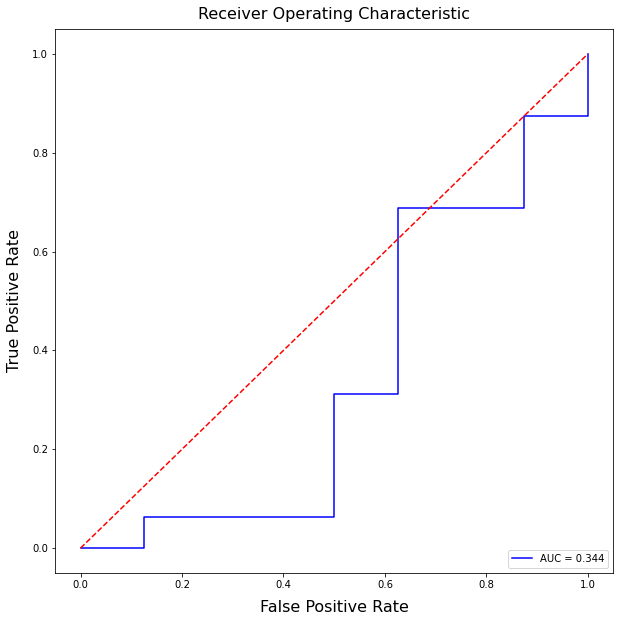

In [26]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.show()

Next, let's plot the precision-recall curve image-wise:

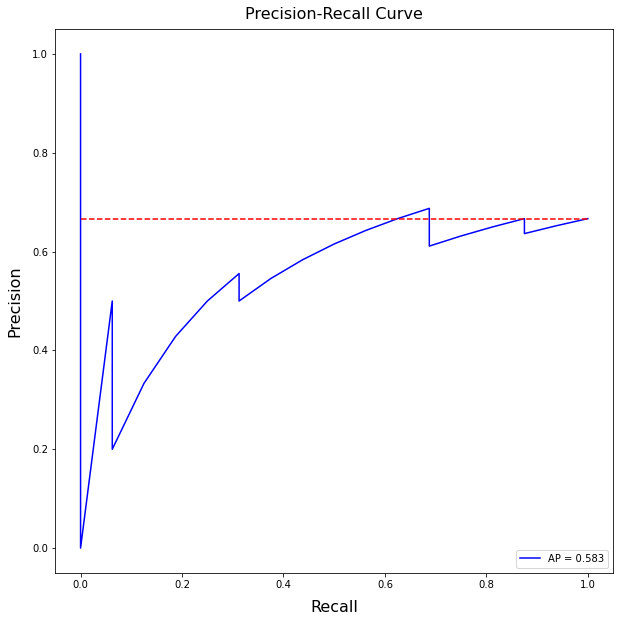

In [27]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [28]:
# Create single array of predictions and labels 
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.543
Balanced  Accuracy: 0.376
Precision: 0.803
Recall: 0.614
F1 score: 0.696


Next, let's plot the roc curve spectra-wise:

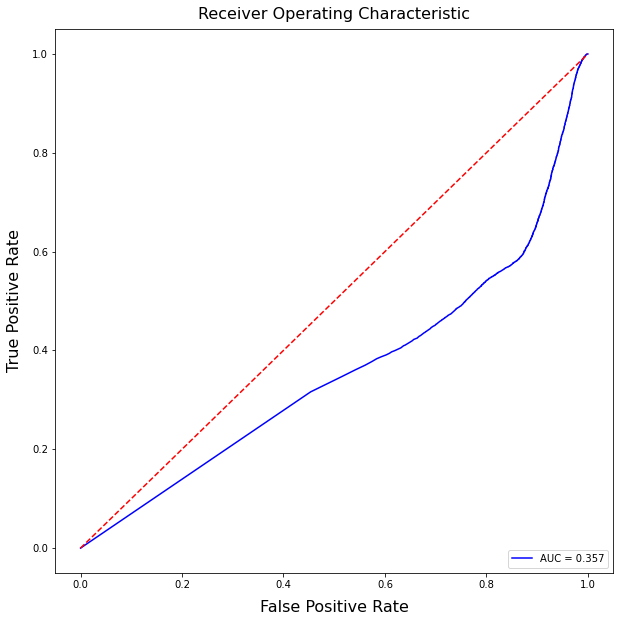

In [29]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

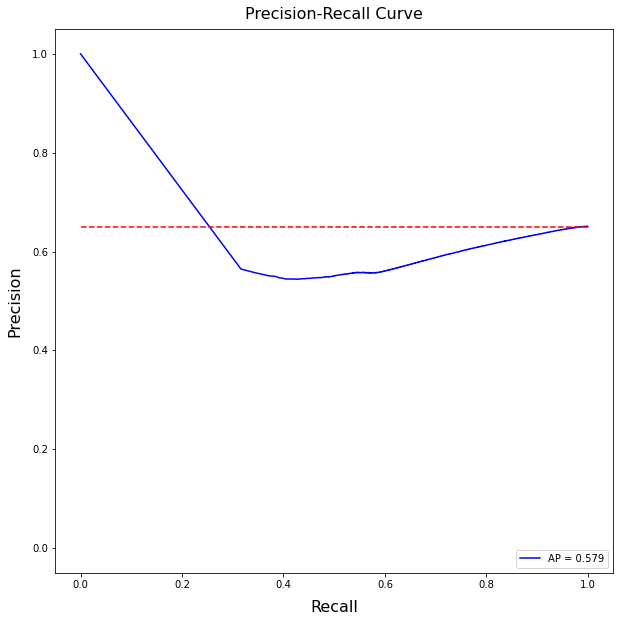

In [30]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  predictions_and_labels[:, 1], predictions_and_labels[:, 0])
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1]==1) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.show()

Next, let's plot the prediction heatmap for every sample:

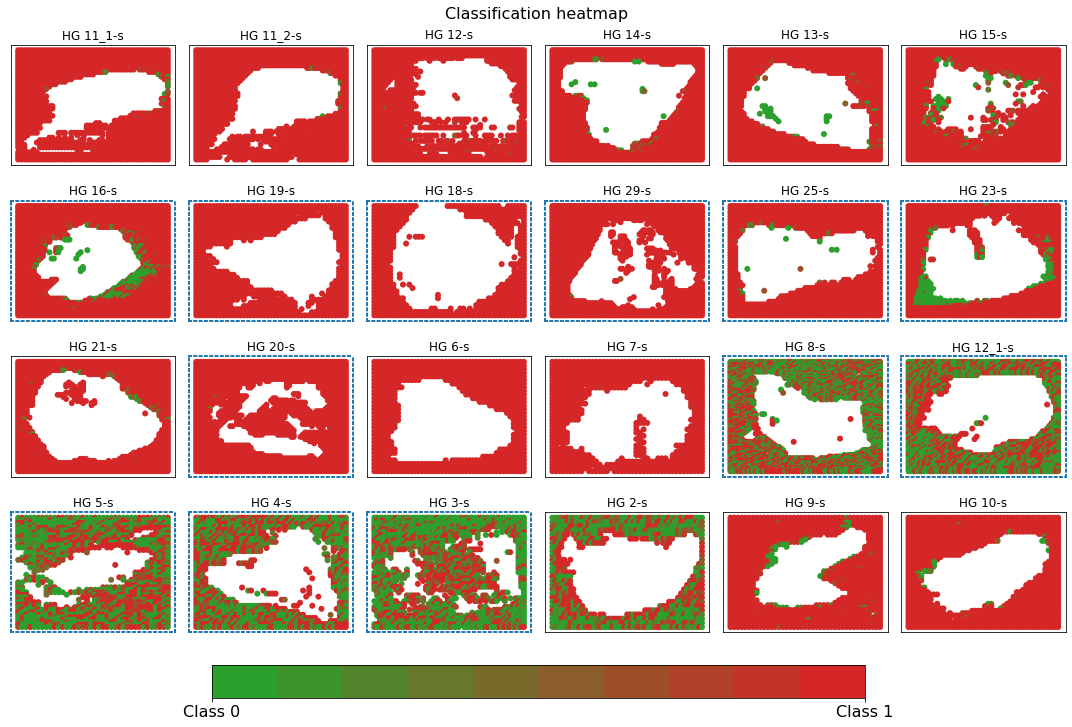

In [31]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      s_spectras_info[(s_spectras_info.file_name == key) &
                      ~s_spectras_info.is_tissue].x_coordinate - 1,
      s_spectras_info[(s_spectras_info.file_name == key) &
                      ~s_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key}")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.show()

Next, let's plot the prediction distribution for every sample:

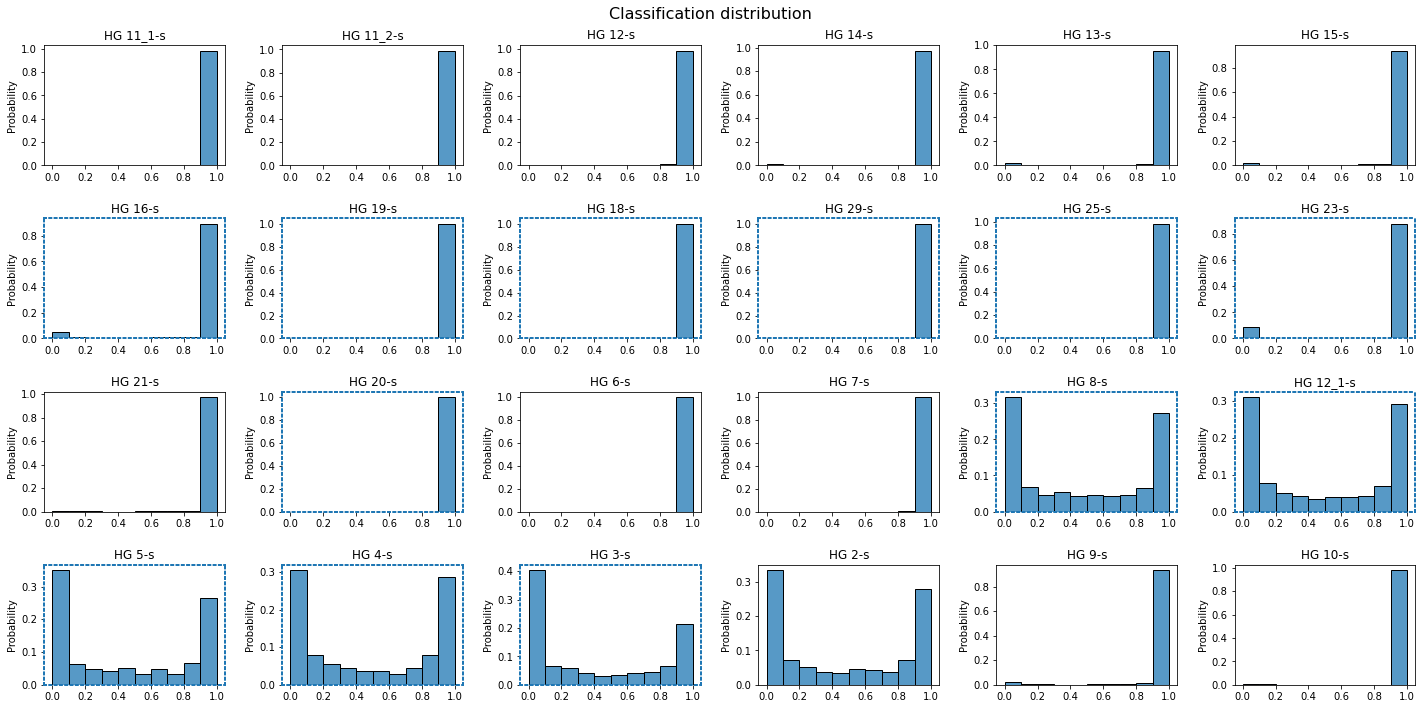

In [32]:
# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key}")

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.show()

### ***Approach 4 - Leave one image out + standardization + non matching morphology sample removal:***

##### ***Training:***
Next, let"s create a classification model for each leave one sample out option:

In [17]:
non_matching = [
    "HG 2-s", "HG 3-s", "HG 5-s", "HG 9-s", "HG 10-s", "HG 13-s", "HG 19-s",
    "HG 25-s", "HG 11_2-s"
]
new_metadata_df = metadata_df[~metadata_df.sample_file_name.isin(non_matching)]
exclude_non_matching = np.isin(file_names, non_matching)

In [38]:
train_metrics = {}
validation_metrics = {}

# Loop over each sample number
for exclude_image, group in tqdm(new_metadata_df.groupby("file_name")):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get all spectra's in the exclude_image and spectra's with non matching
  # morphology to exclude them
  exclude_spectras = (
      np.isin(sample_numbers, group.sample_number.to_list()) |
      exclude_non_matching
  )

  # Create filter for training data - does not include the excluded image
  # and non matching morphology and only include tissue spectra's
  train_filter = ((~exclude_spectras) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Get indexes of training data
  train_indexes = indexes[train_filter]

  # Get indexes of training and validation data
  train_indexes, val_indexes = train_test_split(
      train_indexes, test_size=0.2, random_state=0,
      stratify=labels[train_filter]
  )

  # Create data generators
  train_generator = create_ds(train_indexes, BATCH_SIZE, True)
  validation_generator = create_ds(val_indexes, BATCH_SIZE, True)

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      '.', f"approach_4/excluded_{exclude_image}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False,
      monitor="val_binary_accuracy", mode="max", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(
      optimizer, loss=losses.BinaryCrossentropy(), metrics=["binary_accuracy"]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPHOCS,
      callbacks=[model_checkpoint_callback, model_es_callback]
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_image] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_image] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/100
51/51 [==============================] - 23s 409ms/step - loss: 0.0767 - binary_accuracy: 0.9692 - val_loss: 0.5822 - val_binary_accuracy: 0.8803
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 11-11-12-s\assets
Epoch 2/100
51/51 [==============================] - 21s 420ms/step - loss: 0.0115 - binary_accuracy: 0.9964 - val_loss: 0.0157 - val_binary_accuracy: 0.9951
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 11-11-12-s\assets
Epoch 3/100
51/51 [==============================] - 21s 415ms/step - loss: 0.0045 - binary_accuracy: 0.9984 - val_loss: 0.0139 - val_binary_accuracy: 0.9969
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 11-11-12-s\assets
Epoch 4/100
51/51 [==============================] - 20s 393ms/step - loss: 0.0021 - binary_accuracy: 0.9994 - val_loss: 0.0145 - val_binary_accuracy: 0.9960
Epoch 5/100
51/51 [==============================] - 20s 384ms/step - loss: 0.0026 - binary_accuracy: 0.9992 - val_loss: 0.0137 - val_

 14%|█▍        | 1/7 [03:58<23:51, 238.61s/it]

##############################
Epoch 1/100
56/56 [==============================] - 23s 403ms/step - loss: 0.0784 - binary_accuracy: 0.9697 - val_loss: 0.0607 - val_binary_accuracy: 0.9850
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 14-13-s\assets
Epoch 2/100
56/56 [==============================] - 23s 405ms/step - loss: 0.0112 - binary_accuracy: 0.9967 - val_loss: 0.0279 - val_binary_accuracy: 0.9924
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 14-13-s\assets
Epoch 3/100
56/56 [==============================] - 22s 387ms/step - loss: 0.0033 - binary_accuracy: 0.9989 - val_loss: 0.0088 - val_binary_accuracy: 0.9966
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 14-13-s\assets
Epoch 4/100
56/56 [==============================] - 22s 398ms/step - loss: 0.0025 - binary_accuracy: 0.9993 - val_loss: 0.0096 - val_binary_accuracy: 0.9960
Epoch 5/100
56/56 [==============================] - 23s 406ms/step - loss: 0.0032 - binary_accuracy: 0.9992 - v

 29%|██▊       | 2/7 [09:24<24:08, 289.79s/it]

##############################
Epoch 1/100
54/54 [==============================] - 21s 372ms/step - loss: 0.0565 - binary_accuracy: 0.9787 - val_loss: 0.0181 - val_binary_accuracy: 0.9959
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 16-15-s\assets
Epoch 2/100
54/54 [==============================] - 20s 372ms/step - loss: 0.0040 - binary_accuracy: 0.9989 - val_loss: 0.0141 - val_binary_accuracy: 0.9983
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 16-15-s\assets
Epoch 3/100
54/54 [==============================] - 20s 365ms/step - loss: 0.0021 - binary_accuracy: 0.9993 - val_loss: 0.0130 - val_binary_accuracy: 0.9974
Epoch 4/100
54/54 [==============================] - 20s 377ms/step - loss: 9.6716e-04 - binary_accuracy: 0.9996 - val_loss: 0.0154 - val_binary_accuracy: 0.9962
Epoch 5/100
54/54 [==============================] - 20s 372ms/step - loss: 0.0021 - binary_accuracy: 0.9994 - val_loss: 0.0245 - val_binary_accuracy: 0.9948
Epoch 6/100
54/54 [======

 43%|████▎     | 3/7 [12:41<16:30, 247.52s/it]

##############################
Epoch 1/100
59/59 [==============================] - 24s 402ms/step - loss: 0.0821 - binary_accuracy: 0.9718 - val_loss: 0.1022 - val_binary_accuracy: 0.9681
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 19-18-s\assets
Epoch 2/100
59/59 [==============================] - 23s 395ms/step - loss: 0.0062 - binary_accuracy: 0.9981 - val_loss: 0.0078 - val_binary_accuracy: 0.9973
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 19-18-s\assets
Epoch 3/100
59/59 [==============================] - 23s 388ms/step - loss: 0.0027 - binary_accuracy: 0.9991 - val_loss: 0.0159 - val_binary_accuracy: 0.9963
Epoch 4/100
59/59 [==============================] - 23s 389ms/step - loss: 0.0017 - binary_accuracy: 0.9996 - val_loss: 0.0196 - val_binary_accuracy: 0.9954
Epoch 5/100
59/59 [==============================] - 23s 396ms/step - loss: 0.0088 - binary_accuracy: 0.9976 - val_loss: 0.0215 - val_binary_accuracy: 0.9944
Epoch 6/100
59/59 [==========

 57%|█████▋    | 4/7 [15:56<11:20, 226.86s/it]

##############################
Epoch 1/100
41/41 [==============================] - 18s 423ms/step - loss: 0.0834 - binary_accuracy: 0.9680 - val_loss: 0.5075 - val_binary_accuracy: 0.8462
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 29-25-23-21-20-s\assets
Epoch 2/100
41/41 [==============================] - 17s 412ms/step - loss: 0.0041 - binary_accuracy: 0.9987 - val_loss: 0.0304 - val_binary_accuracy: 0.9946
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 29-25-23-21-20-s\assets
Epoch 3/100
41/41 [==============================] - 17s 413ms/step - loss: 0.0014 - binary_accuracy: 0.9997 - val_loss: 0.0059 - val_binary_accuracy: 0.9988
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 29-25-23-21-20-s\assets
Epoch 4/100
41/41 [==============================] - 16s 391ms/step - loss: 0.0021 - binary_accuracy: 0.9994 - val_loss: 0.0024 - val_binary_accuracy: 0.9996
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 29-25-23-21-20-s\assets
E

 71%|███████▏  | 5/7 [19:33<07:26, 223.22s/it]

##############################
Epoch 1/100
58/58 [==============================] - 25s 421ms/step - loss: 0.0810 - binary_accuracy: 0.9695 - val_loss: 0.0528 - val_binary_accuracy: 0.9867
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 6-7-s\assets
Epoch 2/100
58/58 [==============================] - 24s 419ms/step - loss: 0.0095 - binary_accuracy: 0.9974 - val_loss: 0.0153 - val_binary_accuracy: 0.9959
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 6-7-s\assets
Epoch 3/100
58/58 [==============================] - 24s 402ms/step - loss: 0.0022 - binary_accuracy: 0.9995 - val_loss: 0.0095 - val_binary_accuracy: 0.9976
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 6-7-s\assets
Epoch 4/100
58/58 [==============================] - 25s 421ms/step - loss: 0.0014 - binary_accuracy: 0.9995 - val_loss: 0.0118 - val_binary_accuracy: 0.9967
Epoch 5/100
58/58 [==============================] - 23s 397ms/step - loss: 0.0012 - binary_accuracy: 0.9995 - val_los

 86%|████████▌ | 6/7 [23:23<03:45, 225.64s/it]

##############################
Epoch 1/100
44/44 [==============================] - 19s 416ms/step - loss: 0.0886 - binary_accuracy: 0.9639 - val_loss: 0.0519 - val_binary_accuracy: 0.9876
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 8-12-5-4-3-2-s\assets
Epoch 2/100
44/44 [==============================] - 19s 428ms/step - loss: 0.0080 - binary_accuracy: 0.9976 - val_loss: 0.0184 - val_binary_accuracy: 0.9940
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 8-12-5-4-3-2-s\assets
Epoch 3/100
44/44 [==============================] - 16s 364ms/step - loss: 0.0020 - binary_accuracy: 0.9994 - val_loss: 0.0049 - val_binary_accuracy: 0.9975
INFO:tensorflow:Assets written to: .\approach_3/excluded_HG 8-12-5-4-3-2-s\assets
Epoch 4/100
44/44 [==============================] - 17s 379ms/step - loss: 8.2920e-04 - binary_accuracy: 0.9997 - val_loss: 0.0080 - val_binary_accuracy: 0.9950
Epoch 5/100
44/44 [==============================] - 16s 362ms/step - loss: 0.0017 - bi

100%|██████████| 7/7 [26:23<00:00, 226.26s/it]

##############################


In [39]:
train_metrics

{'HG 11-11-12-s': [7.980039663380012e-05, 1.0],
 'HG 14-13-s': [0.0007921746582724154, 0.9998586773872375],
 'HG 16-15-s': [0.00039994879625737667, 0.9998544454574585],
 'HG 19-18-s': [0.001830084016546607, 0.9997323155403137],
 'HG 29-25-23-21-20-s': [0.002089797519147396, 0.9999032020568848],
 'HG 6-7-s': [2.7305857656756416e-05, 1.0],
 'HG 8-12-5-4-3-2-s': [0.001124678528867662, 0.9999111890792847]}

In [40]:
validation_metrics

{'HG 11-11-12-s': [0.013878008350729942, 0.9969230890274048],
 'HG 14-13-s': [0.007869451306760311, 0.9980214834213257],
 'HG 16-15-s': [0.014149180613458157, 0.9982532858848572],
 'HG 19-18-s': [0.0077773029915988445, 0.9973233342170715],
 'HG 29-25-23-21-20-s': [0.0024242126382887363, 0.9996126890182495],
 'HG 6-7-s': [0.009540675207972527, 0.997554361820221],
 'HG 8-12-5-4-3-2-s': [0.004858605097979307, 0.9975132942199707]}

##### ***Evaluation on tissue spectra's:***

Next, let's get the prediction of each of left out sample spectra's:

In [42]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(new_metadata_df.iterrows(), total=new_metadata_df.shape[0],
                           desc="MSI Loop"):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data
  test_filter = ((file_names == row.sample_file_name) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE, True)

  # Get saved model path
  model_path = os.path.join(
      '.', f"approach_4/excluded_{row.file_name}/"
  )

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

MSI Loop:  62%|██████▎   | 15/24 [01:10<00:42,  4.67s/it]


Next, let's get some statistics about each left out sample predictions:

In [43]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,HG 11_1-s,0.9954942465,1.0000000000,1.0000000000,0.9999763966,0.0002752695,1,1
1,HG 12-s,0.0056562228,1.0000000000,0.9999983311,0.9357541203,0.1929973662,1,1
2,HG 14-s,0.0000213934,0.9999979734,0.9701429605,0.8017376065,0.3140293956,1,1
3,HG 15-s,0.0000000000,1.0000000000,0.0015238689,0.2910719812,0.4168043435,1,0
4,HG 16-s,0.0000000000,0.9989359975,0.0000000032,0.0300467163,0.1466489583,0,0
5,HG 18-s,0.9735399485,0.9999878407,0.9997265935,0.9996013641,0.0009057470,0,1
6,HG 29-s,0.0000000008,1.0000000000,0.9954784513,0.8493916392,0.3142931163,0,1
7,HG 23-s,0.0000000000,0.9996355772,0.6716936231,0.5130209327,0.4633272290,0,1
8,HG 21-s,0.4409888983,0.9999936819,0.9992146492,0.9982128143,0.0141971856,1,1
9,HG 20-s,0.0004966313,0.9999608994,0.9992488027,0.9479253888,0.1698915958,0,1


Next, let's evaluate the classification performance:

In [44]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.667
Balanced  Accuracy: 0.550
Precision: 0.692
Recall: 0.900
F1 score: 0.783


Next, let's plot the roc curve:

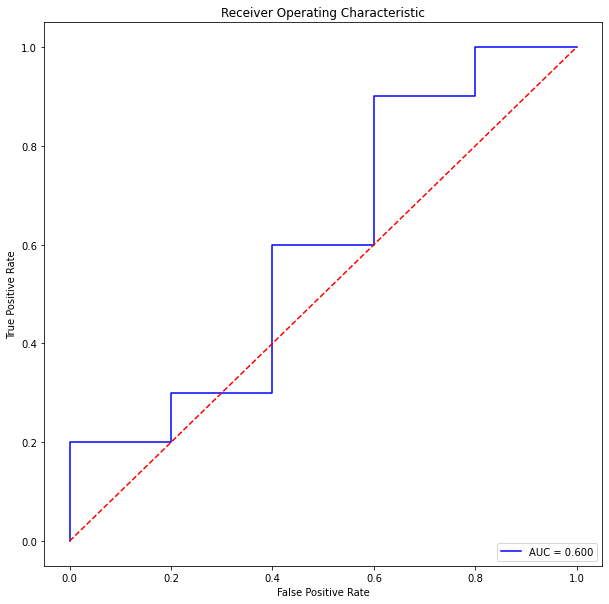

In [45]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

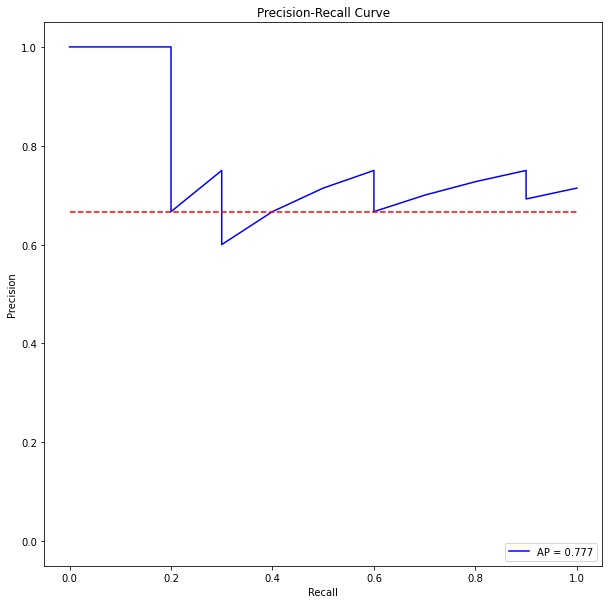

In [46]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

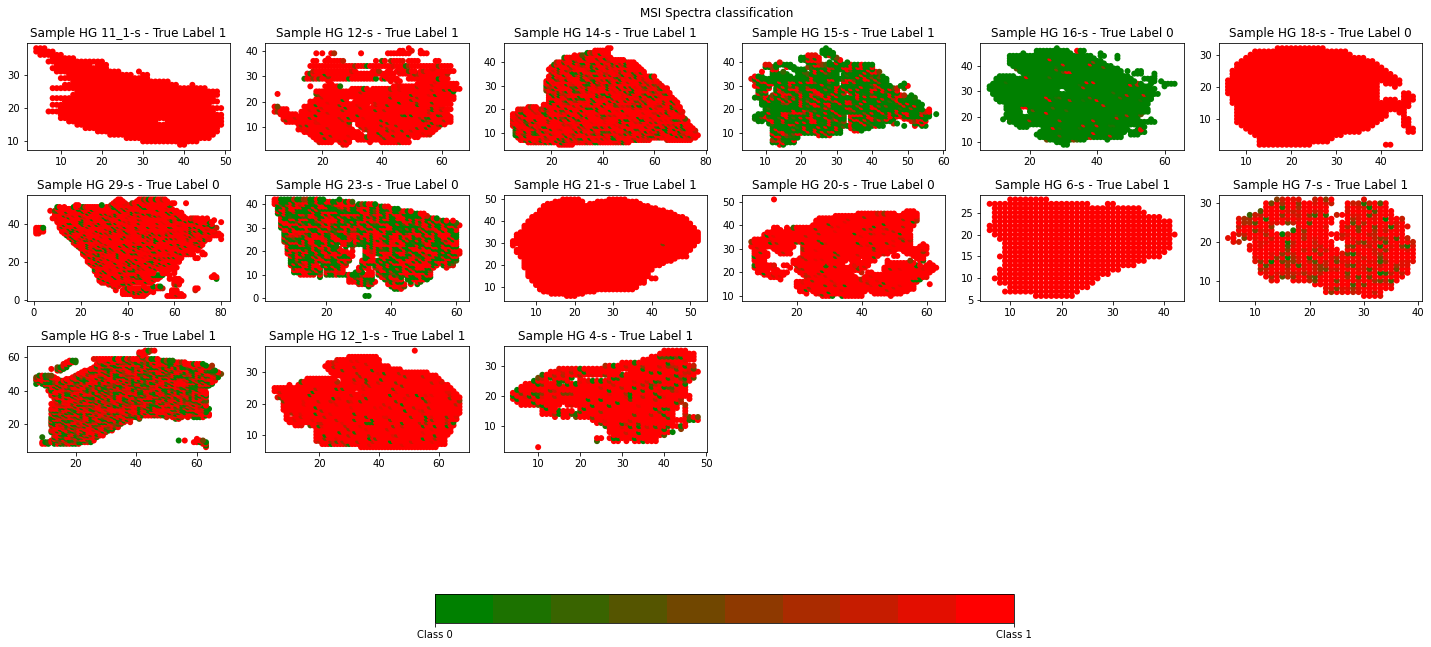

In [47]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(file_names == key) & is_tissue],
                  y_coordinates[(file_names == key) & is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

##### ***Evaluation on non tissue spectra's:***

Next, let's get the prediction of each of left out sample non tissue spectra's:

In [50]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(new_metadata_df.iterrows(), total=new_metadata_df.shape[0],
                           desc="MSI Loop"):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data
  test_filter = ((file_names == row.sample_file_name) & ~is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE, False)

  # Get saved model path
  model_path = os.path.join(
      '.', f"approach_4/excluded_{row.file_name}/"
  )

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 15/15 [01:11<00:00,  4.74s/it]


Next, let's get some statistics about each left out sample predictions:

In [51]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,HG 11_1-s,0.4608274400,0.4616675377,0.4610406458,0.4610605538,0.0001154071,1,0
1,HG 12-s,0.4608510435,0.4617376029,0.4610477984,0.4610825181,0.0001325770,1,0
2,HG 14-s,0.9993653893,0.9993692040,0.9993670583,0.9993669987,0.0000008647,1,1
3,HG 15-s,0.9988532066,0.9988558292,0.9988549948,0.9988548756,0.0000004147,1,1
4,HG 16-s,0.9988532066,0.9988559484,0.9988549948,0.9988549352,0.0000003078,0,1
5,HG 18-s,0.9978191853,0.9978221655,0.9978201389,0.9978203177,0.0000004577,0,1
6,HG 29-s,0.9997159839,0.9997165799,0.9997163415,0.9997162819,0.0000001025,0,1
7,HG 23-s,0.9997161031,0.9997166991,0.9997163415,0.9997163415,0.0000000956,0,1
8,HG 21-s,0.9997161031,0.9997166991,0.9997163415,0.9997162819,0.0000001019,1,1
9,HG 20-s,0.9997161031,0.9997165799,0.9997163415,0.9997163415,0.0000001160,0,1


Next, let's evaluate the classification performance:

In [52]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.333
Balanced  Accuracy: 0.250
Precision: 0.500
Recall: 0.500
F1 score: 0.500


Next, let's plot the roc curve:

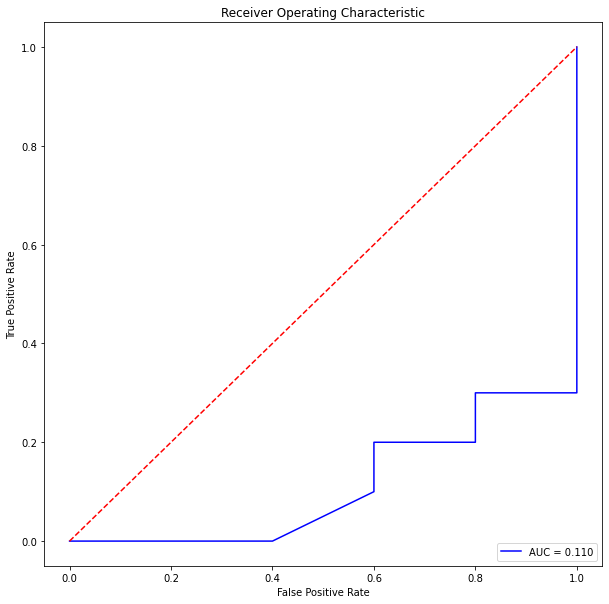

In [53]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

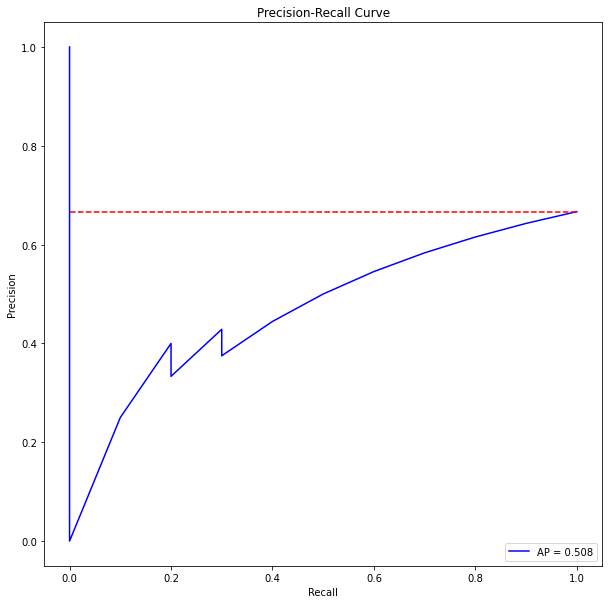

In [54]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

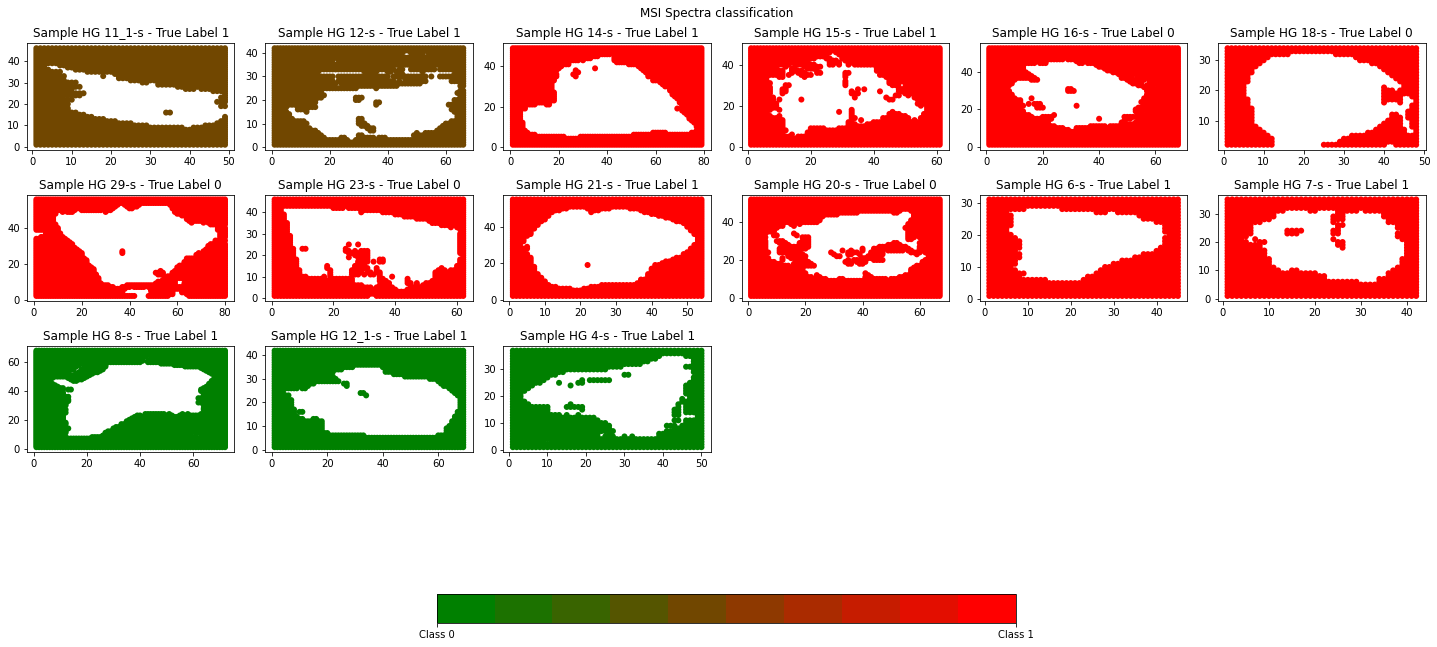

In [55]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(file_names == key) & ~is_tissue],
                  y_coordinates[(file_names == key) & ~is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***MSI parsers closing:***

Next, let"s close MSI parsers:

In [54]:
# Closing parsers
for reader in parsers.values():
  if reader.m:
    reader.m.close()